### Initialize notebook

In [1]:
# Torch imports
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
import PIL.Image as IMG
from torch.utils.data.sampler import WeightedRandomSampler

# Other imports
import matplotlib.pyplot as plt
import numpy as np
import os
os.chdir('/home/ak/Spring2018/ature')

from neuralnet.utils.datasets import DriveDatasetFromFile, DriveDatasetFromImageObj

from utils import img_utils as imgutil
from commons.IMAGE import SegmentedImage
from neuralnet.trainer import NNTrainer
import neuralnet.utils.measurements as mnt

sep = os.sep

# Define folders (create them if needed)
Dirs = {}

Dirs['train_data']= 'data'+sep+'DRIVE'+sep+'training'+sep +'patches'
Dirs['test_data'] = 'data'+sep+'DRIVE'+sep+'test' +sep+ 'patches'
Dirs['checkpoint']   = 'assests' +sep+ 'nnet_models'

Dirs['data']      = 'data'+sep+'DRIVE'+sep+'test'
Dirs['images']    = Dirs['data'] +sep+ 'images'
Dirs['mask']      = Dirs['data'] +sep+ 'mask'
Dirs['truth']     = Dirs['data'] +sep+ '1st_manual'
Dirs['segmented'] = Dirs['data'] +sep+ 'drive_segmented'

for k, folder in Dirs.items():
    os.makedirs(folder, exist_ok=True)

# Set up execution flags
Flags = {}
Flags['useGPU'] = False

classes = ('white', 'green', 'black', 'red')

### Define the network

In [2]:
class Net(nn.Module):
    def __init__(self, width, channels):
        super(Net, self).__init__()
        
        self.channels = channels
        self.width = width
        
    
        self.kern_size = 5
        self.kern_stride = 2      
        self.kern_padding = 2
        self.mxp_kern_size = 2
        self.mxp_stride = 2 
        self.pool1 = nn.MaxPool2d(kernel_size=self.mxp_kern_size, stride=self.mxp_stride)
        self.conv1 = nn.Conv2d(self.channels, 20, self.kern_size, 
                               stride=self.kern_stride, padding=self.kern_padding)
        self._update_output_size()
        
        
        self.kern_size = 5
        self.kern_stride = 1      
        self.kern_padding = 2
        self.mxp_kern_size = 1
        self.mxp_stride = 1 
        self.pool2 = nn.MaxPool2d(kernel_size=self.mxp_kern_size, stride=self.mxp_stride)
        self.conv2 = nn.Conv2d(20, 50, self.kern_size, 
                               stride=self.kern_stride, padding=self.kern_padding)
        self._update_output_size()
        
        
        self.kern_size = 5
        self.kern_stride = 1      
        self.kern_padding = 1
        self.mxp_kern_size = 1
        self.mxp_stride = 1 
        self.pool3 = nn.MaxPool2d(kernel_size=self.mxp_kern_size, stride=self.mxp_stride)
        self.conv3 = nn.Conv2d(50, 50, self.kern_size, 
                               stride=self.kern_stride, padding=self.kern_padding)
        self._update_output_size()
        
        
        
        self.linearWidth = 50*int(self.width)*int(self.width)
        self.fc1 = nn.Linear(self.linearWidth, 100)
        self.fc2 = nn.Linear(100, 20)
        self.fc3 = nn.Linear(20, 4)
        self.sm = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = x.view(-1, self.linearWidth)
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def _update_output_size(self):       
        temp = self.width
        self.width = ((self.width - self.kern_size + 2 * self.kern_padding) / self.kern_stride) + 1
        temp1 = self.width
        self.width = ((self.width - self.mxp_kern_size)/self.mxp_stride) + 1
        print('output width { ' + str(temp) + ' -conv-> ' + str(temp1) + ' -maxpool-> ' + str(self.width) + ' }')

width = 31
channels = 1
net = Net(width, channels)
optimizer = optim.Adam(net.parameters(), lr=0.0005)

output width { 31 -conv-> 16.0 -maxpool-> 8.0 }
output width { 8.0 -conv-> 8.0 -maxpool-> 8.0 }
output width { 8.0 -conv-> 6.0 -maxpool-> 6.0 }


### Load train data

In [8]:
transform = transforms.Compose([
    transforms.ToTensor()])

trainset = DriveDatasetFromFile(data_path=Dirs['train_data'], height=31, width=31, 
                                num_classes=4, transform=transform)
clss, class_counts = np.unique(trainset.labels, return_counts=True)
class_weights = 1.0/class_counts
data_weights = np.array([class_weights[t] for t in trainset.labels]) 
second_min_class_count =  np.partition(class_counts, 1)[1]

sampler = WeightedRandomSampler(data_weights, int(second_min_class_count))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=False, num_workers=3, sampler=sampler)
print(second_min_class_count)

Data file loaded: data/DRIVE/training/patches/25_training.npy
Data file loaded: data/DRIVE/training/patches/37_training.npy
Data file loaded: data/DRIVE/training/patches/35_training.npy
Data file loaded: data/DRIVE/training/patches/38_training.npy
Data file loaded: data/DRIVE/training/patches/34_training.npy
ERROR loading data/DRIVE/training/patches/39_training.npy : cannot reshape array of size 122240896 into shape (189055,962)
Data file loaded: data/DRIVE/training/patches/24_training.npy
Data file loaded: data/DRIVE/training/patches/27_training.npy
Data file loaded: data/DRIVE/training/patches/33_training.npy
Data file loaded: data/DRIVE/training/patches/26_training.npy
Data file loaded: data/DRIVE/training/patches/31_training.npy
Data file loaded: data/DRIVE/training/patches/23_training.npy
Data file loaded: data/DRIVE/training/patches/29_training.npy
ERROR loading data/DRIVE/training/patches/28_training.npy : 
128057


### Load test dataset

In [4]:
transform = transforms.Compose([
    transforms.ToTensor()])

testset = DriveDatasetFromFile(data_path=Dirs['test_data'], height=31, width=31, 
                               num_classes=4, transform=transform)
clss_test, class_counts_test = np.unique(testset.labels, return_counts=True)
class_weights_test = 1.0/class_counts_test

data_weights_test = np.array([class_weights_test[t] for t in testset.labels])
data_weights_test = np.ones_like(testset.labels)

second_min_class_count_test =  np.partition(class_counts_test, 1)[1]

sampler_test = WeightedRandomSampler(data_weights_test, int(second_min_class_count_test))
testloader = torch.utils.data.DataLoader(testset, batch_size=2, shuffle=False, num_workers=3, sampler=sampler_test)
print(second_min_class_count_test)

Data file loaded: data/DRIVE/test/patches/02_test.npy
Data file loaded: data/DRIVE/test/patches/16_test.npy
Data file loaded: data/DRIVE/test/patches/06_test.npy
Data file loaded: data/DRIVE/test/patches/13_test.npy
Data file loaded: data/DRIVE/test/patches/15_test.npy
Data file loaded: data/DRIVE/test/patches/05_test.npy
Data file loaded: data/DRIVE/test/patches/19_test.npy
Data file loaded: data/DRIVE/test/patches/14_test.npy
51082


### Train and evaluate the Network

In [ ]:
trainer = NNTrainer(model=net, checkpoint_dir=Dirs['checkpoint'], checkpoint_file='checkpoint4Way.nn.tar')
trainer.resume_from_checkpoint()
trainer.train(optimizer=optimizer, dataloader=trainloader, epochs=3, use_gpu=Flags['useGPU'])
# trainer.resume_from_checkpoint()
acc, y_pred, y_true = trainer.test(dataloader=testloader, use_gpu=Flags['useGPU'], force_checkpoint=True)
# trainer.test()

Resumed: checkpoint4Way.nn.tar
[epoch: 5, batches: 40] loss: 0.841
[epoch: 5, batches: 80] loss: 0.841
[epoch: 5, batches: 120] loss: 0.839
[epoch: 5, batches: 160] loss: 0.813
[epoch: 5, batches: 200] loss: 0.860
[epoch: 5, batches: 240] loss: 0.822
[epoch: 5, batches: 280] loss: 0.811
[epoch: 5, batches: 320] loss: 0.826
[epoch: 5, batches: 360] loss: 0.835
[epoch: 5, batches: 400] loss: 0.825


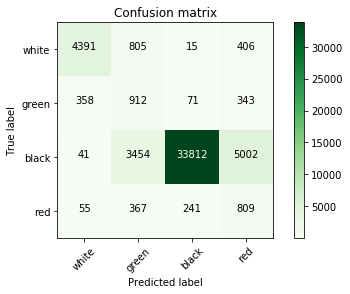

In [10]:
mnt.plot_confusion_matrix(y_pred=y_pred, y_true=y_true, classes=classes)

### Check per-class performance

In [ ]:
class_correct = list(0. for i in range(4))
class_total = list(0. for i in range(4))
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1
for i in range(4):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

### Convolve throughout the image to generate segmented image based on trained Network

In [14]:
input_image = '19_test.tif'

def get_mask_file(file_name): 
    return file_name.split('_')[0] + '_test_mask.gif'

def get_ground_truth_file(file_name): 
    return file_name.split('_')[0] + '_manual1.gif'

def get_segmented_file(file_name):
    return file_name + '_SEG.PNG'

img_obj = SegmentedImage()

img_obj.load_file(data_dir=Dirs['images'], file_name=input_image)
img_obj.res['orig'] = img_obj.image_arr[:, :, 1]
img_obj.working_arr = img_obj.image_arr[:, :, 1]
img_obj.working_arr = imgutil.whiten_image2d(img_obj.working_arr)

img_obj.load_mask(mask_dir=Dirs['mask'], fget_mask=get_mask_file, erode=True)
img_obj.load_ground_truth(gt_dir=Dirs['truth'], fget_ground_truth=get_ground_truth_file)

segmented_file = os.path.join(Dirs['segmented'], get_segmented_file(input_image))
img_obj.res['segmented'] = imgutil.get_image_as_array(segmented_file, channels=1)

transform = transforms.Compose([transforms.ToTensor()])
dtest = DriveDatasetFromImageObj(img_obj=img_obj, patch_size=31, transform=transform, num_classes=4)
dclss, d_cls_count = np.unique(dtest.labels, return_counts=True)
dclass_weights = 1.0/d_cls_count
ddata_weights = np.array([dclass_weights[t] for t in dtest.labels]) 

dsampler = WeightedRandomSampler(ddata_weights, dtest.data.shape[0])
dtestloader = torch.utils.data.DataLoader(dtest, batch_size=1, shuffle=False, num_workers=1, sampler=dsampler)

Mask loaded: 19_test_mask.gif
Ground truth loaded: 19_manual1.gif


In [15]:
img_obj.res['seg'] = np.zeros_like(img_obj.working_arr)
for i, j, image, label in dtestloader:
    if Flags['useGPU']:
        images = image.cuda()
        label = label.cuda()
    outputs = trainer.model(Variable(image))
    _, predicted = torch.max(outputs.data, 1)
    if predicted[0]==3 or predicted[0] == 0:
        img_obj.res['seg'][i, j] = 255

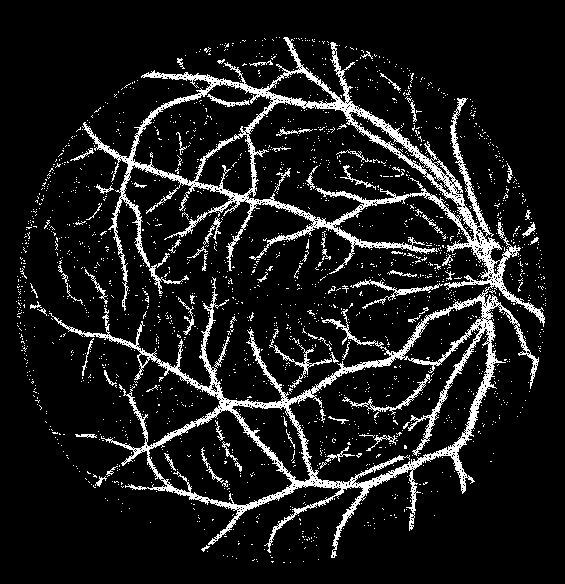

In [10]:
IMG.fromarray(img_obj.res['seg'])

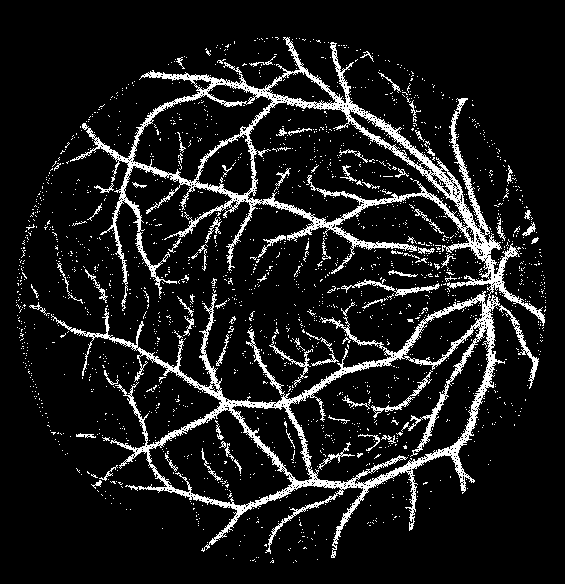

In [16]:
IMG.fromarray(img_obj.res['seg'])

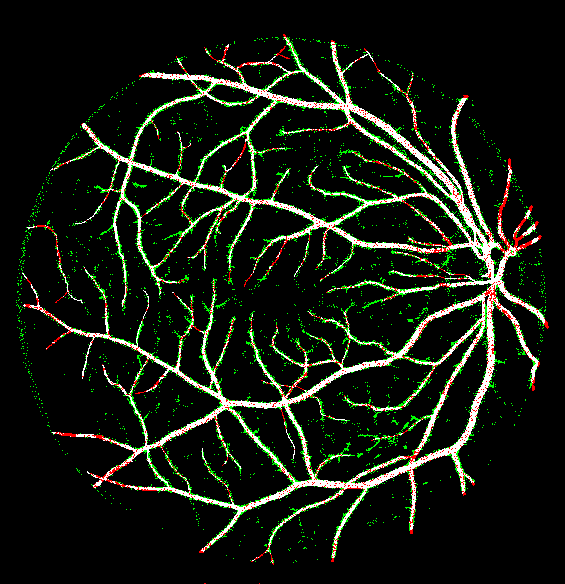

In [18]:
IMG.fromarray(imgutil.get_rgb_scores(img_obj.res['seg'], img_obj.ground_truth))